In [104]:
# Import packages
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

%matplotlib inline

In [105]:
# Load the dataset first column is the index
df = pd.read_csv('USArrests.csv', index_col=0)

This dataset consists of statistics for arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973, as well as the percentage of the population living in urban areas.

In [106]:
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


In [107]:
# Check for missing values
df.isnull().sum()

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


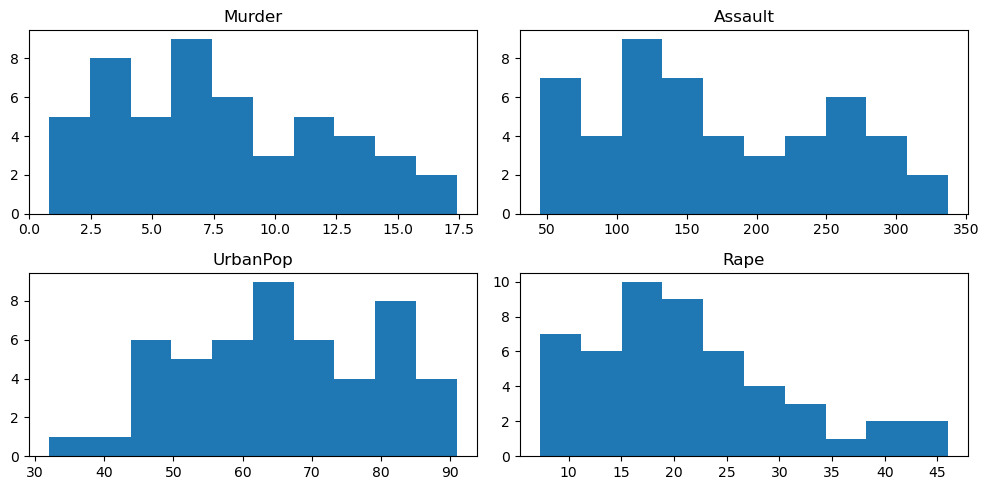

In [109]:
# Plot histograms
df.hist(grid=False, figsize=(10, 5))
plt.tight_layout()
plt.show()

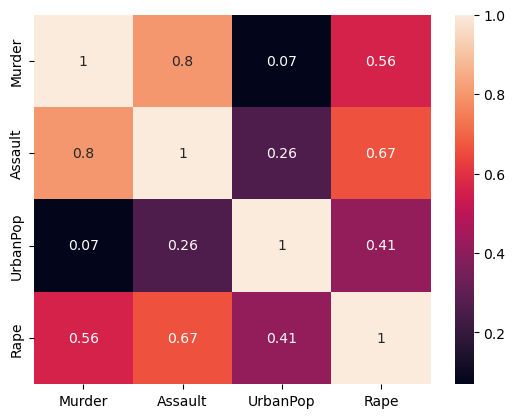

In [110]:
# Correlation using heat map
ax = sns.heatmap(df.corr(), annot=True)

- Rate of arrests for assault has very strong positive correlation with the rate of arrests for murder.
- Rate of arrests for assault has strong positive correlation with the rate of arrests for rape.
- Rate of arrests for murder has moderate positive correlation with the rate of arrests for rape.
- Urbanpopulation percentage has moderate positive correlation with the rate of arrests for rape.
- Urbanpopulation percentage has weak positive correlation with the rate of arrests for assault.
- Urbanpopulation percentage has almost no correlation with the rate of arrests for murder.

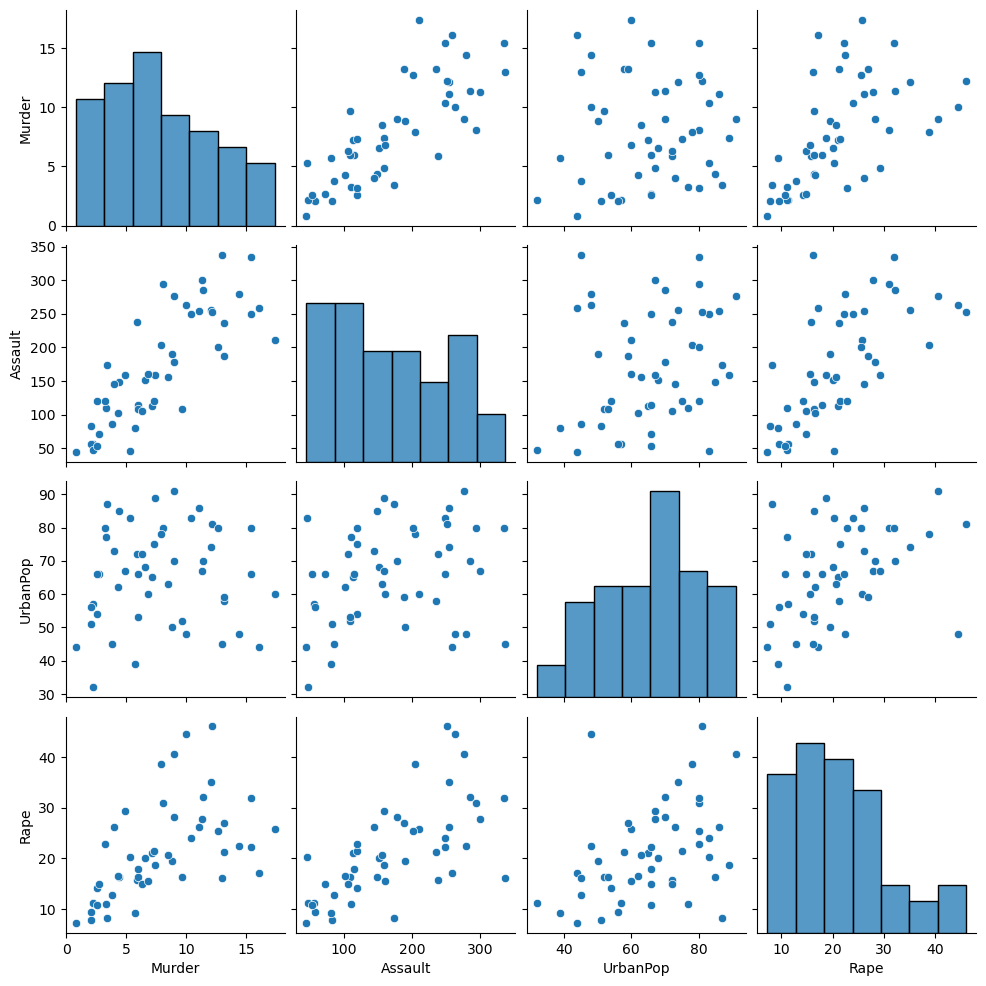

In [111]:
# Pairplot for correlation
sns.pairplot(df);

The pairplots reveal that Murder, Assault, and Rape have a strong correlation with each other. On the other hand, UrbanPop shows no significant correlation with the other variables. Given the high degree of correlation among the input data, it would be appropriate to apply PCA as a way to reduce the number of features.

## PCA

Principal Components Analysis (PCA) is a method for finding the underlying variables (i.e. principal components) that best differentiate the observations by determining the directions along which your data points are most spread out. Since the determination of the principal components is based on finding the direction that maximises the variance, variables with variance that are much higher than the other variables tend to dominate the analysis purely due to their scale. PCA is a dimensionality reduction techinque which is useful when we have a lot of variables, and need to reduce these.

In [112]:
np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)

In [113]:
df_pca.head()

,0,1,2,3
0,64.802,11.448,-2.495,2.408
1,92.827,17.983,20.127,-4.094
2,124.068,-8.830,-1.687,-4.354
3,18.340,16.704,0.210,-0.521
4,107.423,-22.520,6.746,-2.812


In [114]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Standard deviation: [83.73 14.21  6.49  2.48]
Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]
Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [115]:
states = df.index
labels = df.columns

In [116]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(15, 15))    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

# Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

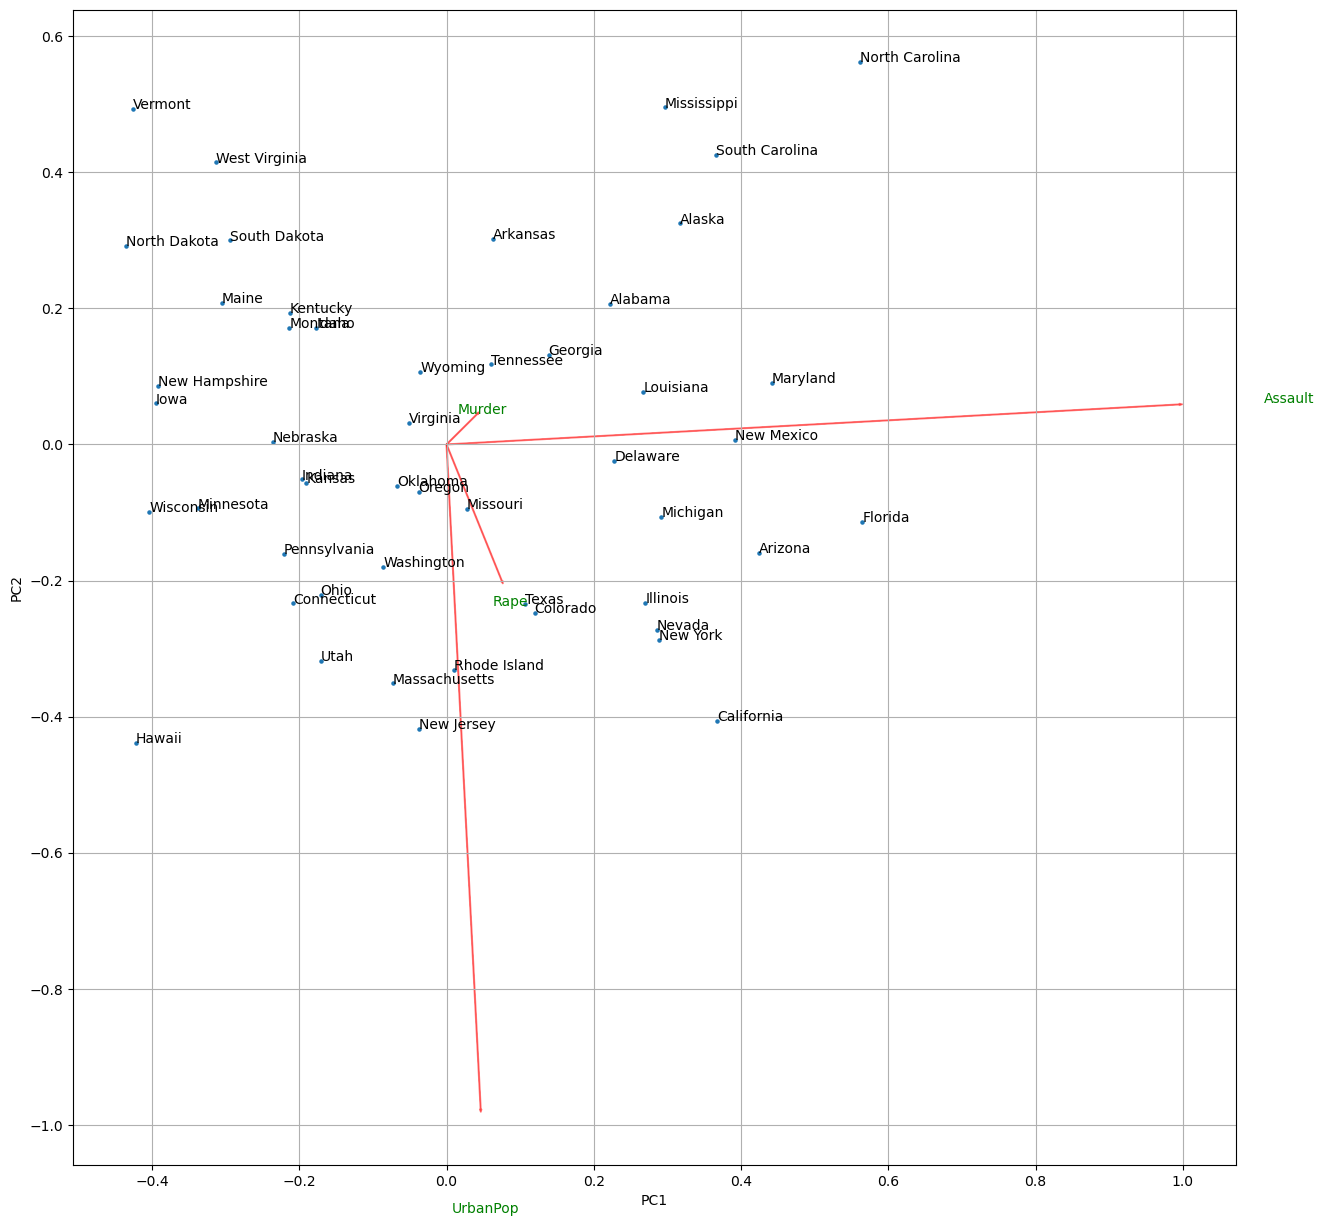

In [117]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

Each point on a biplot represents the projection of an observation, transformed from its original form. The significance of each feature is indicated by the length of the arrows on the biplot, which correspond to the magnitude of the values in the eigenvectors. The biplot shows that Assault and UrbanPop are the most significant features, as their arrows dominate the plot.

This information can also be quantified as follows:

In [118]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


The table indicates that Assault has the greatest importance in the first principle component, while UrbanPop has the highest importance in the second component. This aligns with the observations made from the biplot. The mean values for these features are significantly larger than those of the other features, which may cause them to overpower and overshadow the other features in the analysis. This could explain why the other features are being ignored.

In [119]:
# Standardise data
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)

In [120]:
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


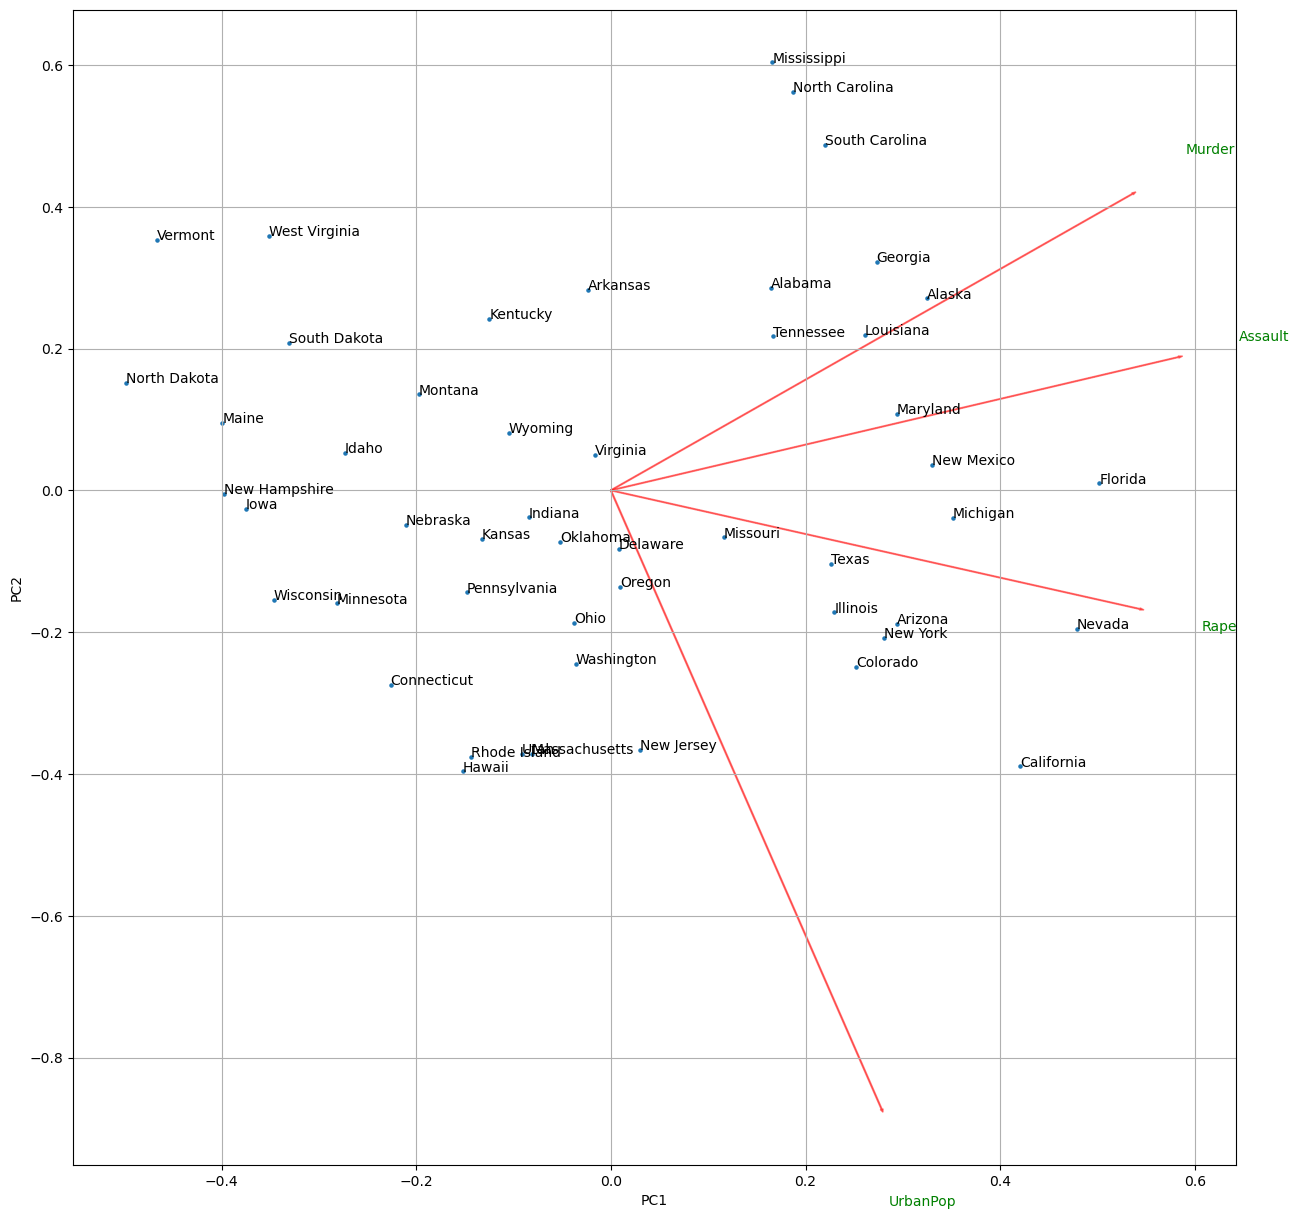

In [121]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

In the results of the standardized data, a larger number of variables are contributing to explaining the variance as the dominating large numbers are no longer present.

In [122]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Examining the feature importance now, it appears that most of the variables are contributing roughly equally, with only a few having low importance.

Text(0.5, 1.0, 'Cumulative Explained Variance')

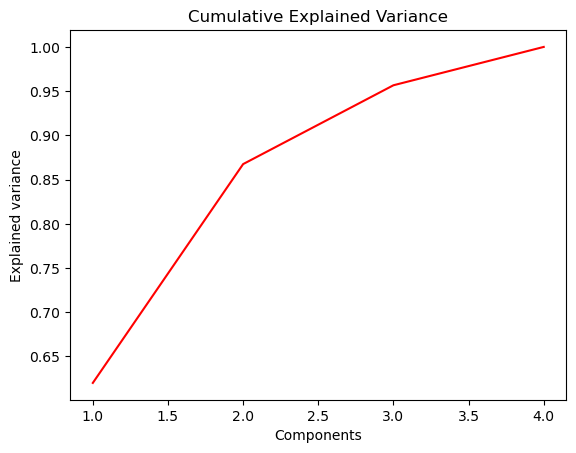

In [123]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

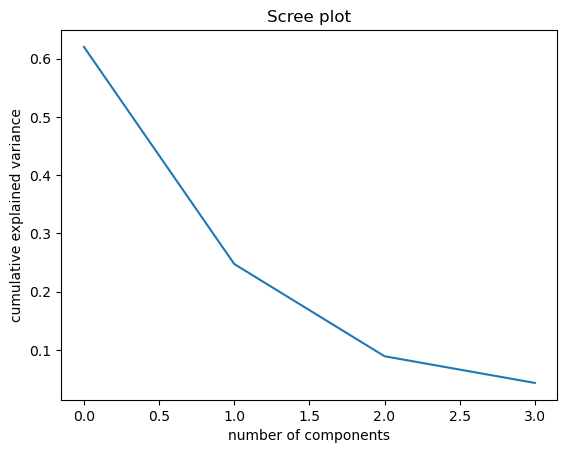

In [124]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The plots above suggest that the first three principal components explain approximately 95% of the variance. This allows us to use them for cluster analysis.

In [125]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.986,1.133,-0.444
Alaska,1.950,1.073,2.040
Arizona,1.763,-0.746,0.055
Arkansas,-0.141,1.120,0.115
California,2.524,-1.543,0.599


## K-Means Clustering

In [126]:
# n_clusters = 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans

KMeans(n_clusters=4, random_state=42)

In [127]:
k_fit = kmeans.fit(pca_df)

In [128]:
silhouette_score(pca_df, labels=kmeans.labels_)

0.37159826683022595

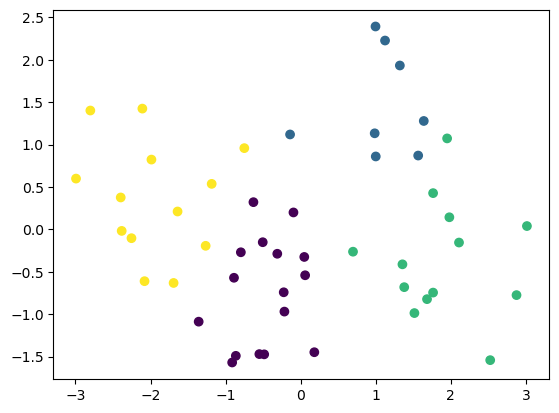

In [130]:
plt.scatter(pca_df.iloc[:,0],pca_df.iloc[:,1],c=k_fit.labels_);

In [132]:
# n_clusters = 2
kmeans = KMeans(n_clusters=2,random_state=42)
k_fit = kmeans.fit(pca_df)

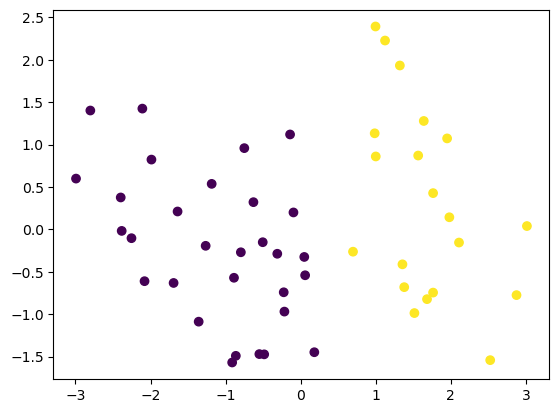

In [133]:
plt.scatter(pca_df.iloc[:,0],pca_df.iloc[:,1],c=k_fit.labels_);

In [135]:
silhouette_score(pca_df,labels=kmeans.labels_)

0.43075151523995503

We see that the better silhouette score is achieved using 2 clusters.

Text(0, 0.5, 'Dim 1')

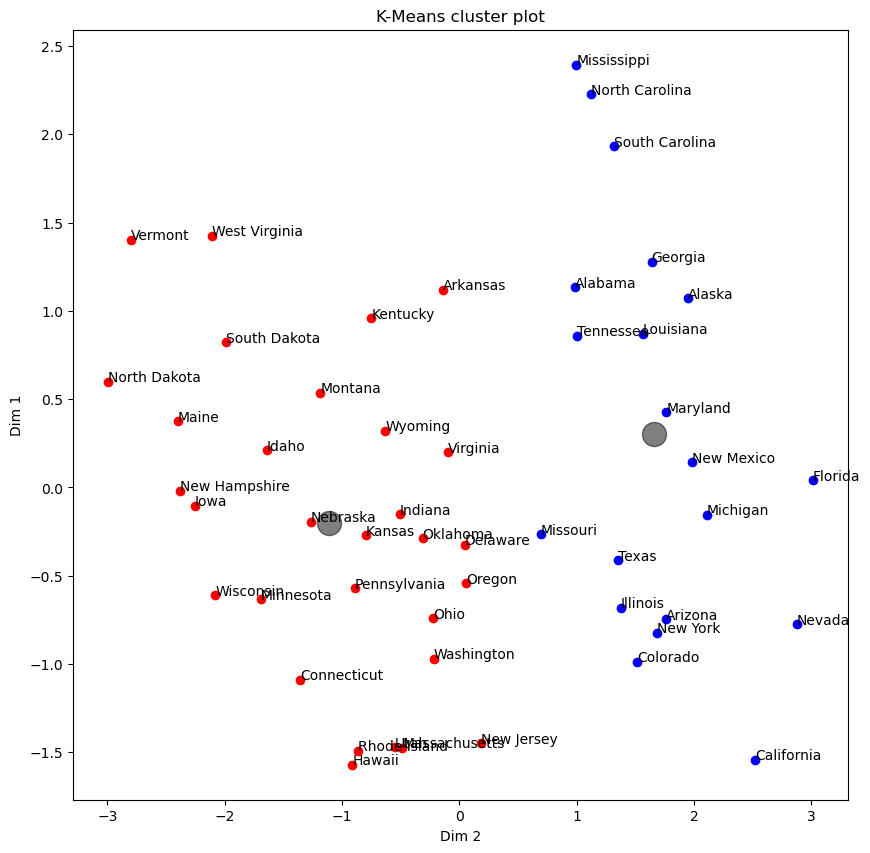

In [139]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots(figsize=(10,10))
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i])
    ax.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='o', c = "black", s=300, alpha=0.5)

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

<AxesSubplot:xlabel='cluster labels', ylabel='Assault'>

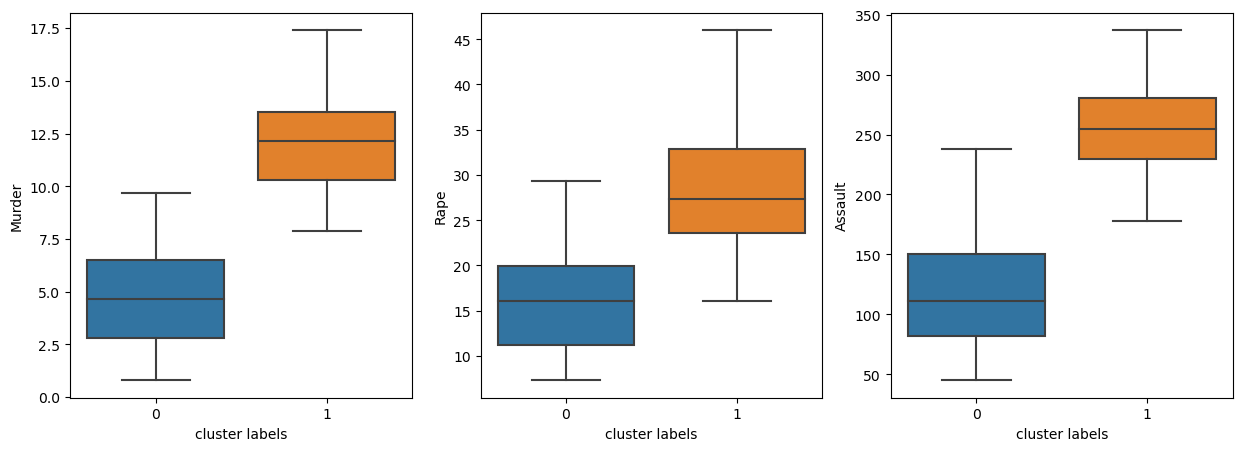

In [140]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.
df['cluster labels']=cluster_labels
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
sns.boxplot(x='cluster labels', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='cluster labels', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='cluster labels', y='Assault', data=df, ax=ax[2])

The box plots above indicate that the states in Group 0 have relatively low rates of murder, assault, and rape and can be considered low-risk states. On the other hand, states in Group 1 have higher crime rates and can be considered high-risk states.

In [141]:
for i in range(2):
    group_indices = np.argwhere(cluster_labels==i).transpose()[0]
    group = np.array(states)[group_indices]
    print(f'Group {i} States:', *group, sep=", ")
    print("\n")     

Group 0 States:, Arkansas, Connecticut, Delaware, Hawaii, Idaho, Indiana, Iowa, Kansas, Kentucky, Maine, Massachusetts, Minnesota, Montana, Nebraska, New Hampshire, New Jersey, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Dakota, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming


Group 1 States:, Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Missouri, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas




## Hierarchical Clustering

Since the goal of the analysis with this dataset is to uncover any unknown patterns without prior assumptions, agglomerative clustering is a more suitable choice.

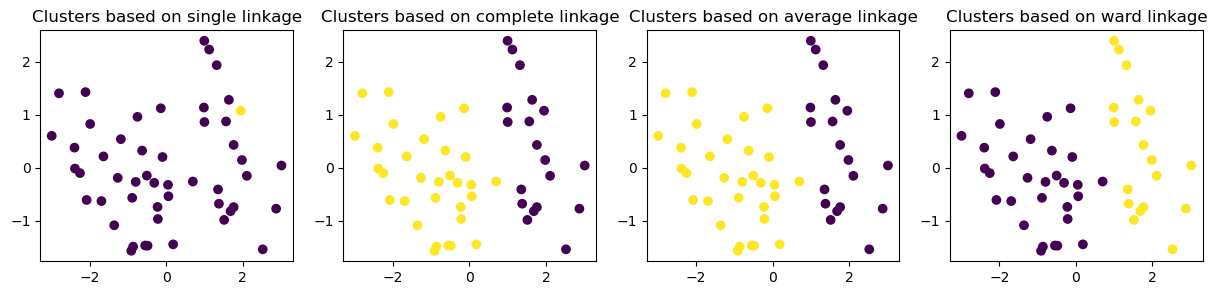

In [97]:
X = pca_df.values.reshape(-1, 3)
linkage_types = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=[15,3])
for i, l in enumerate(linkage_types):
  plt.subplot(1, 4, i+1)
  cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage=l)
  cluster.fit_predict(X)

  ax = plt.scatter(X[:,0], X[:,1], c=cluster.labels_)
  plt.title('Clusters based on {} linkage'.format(l))
 
L = 'complete'

We plot the various dendograms for single, complete, average and ward linkage. For distance metrics between observations we use Euclidean distance.

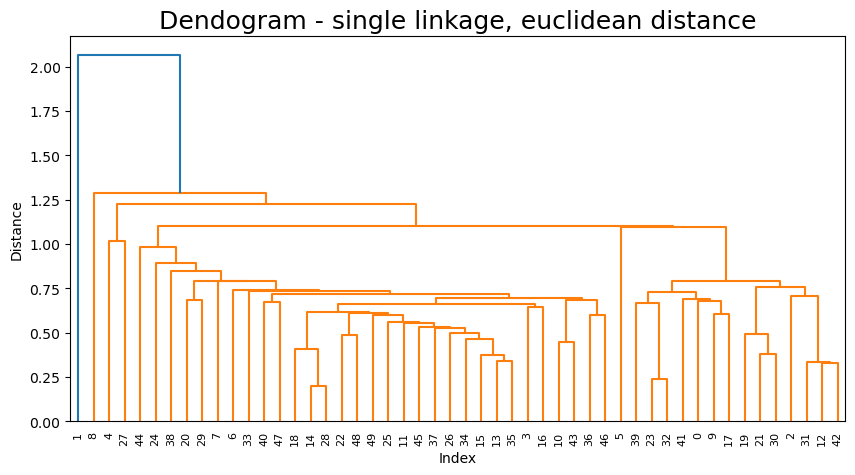

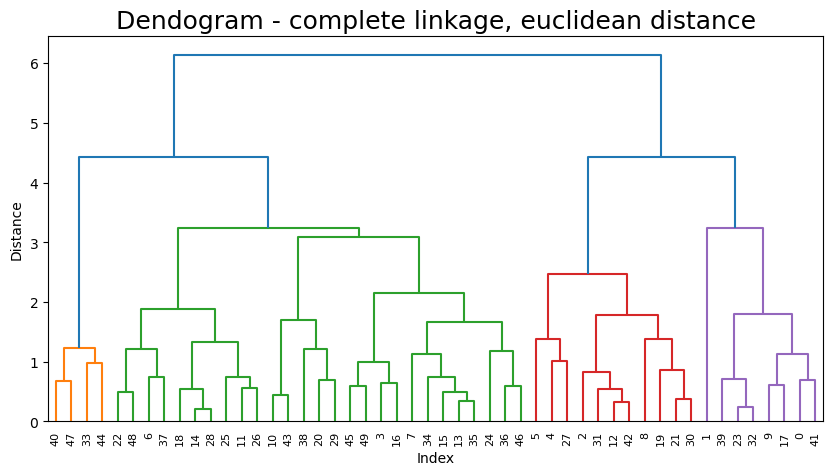

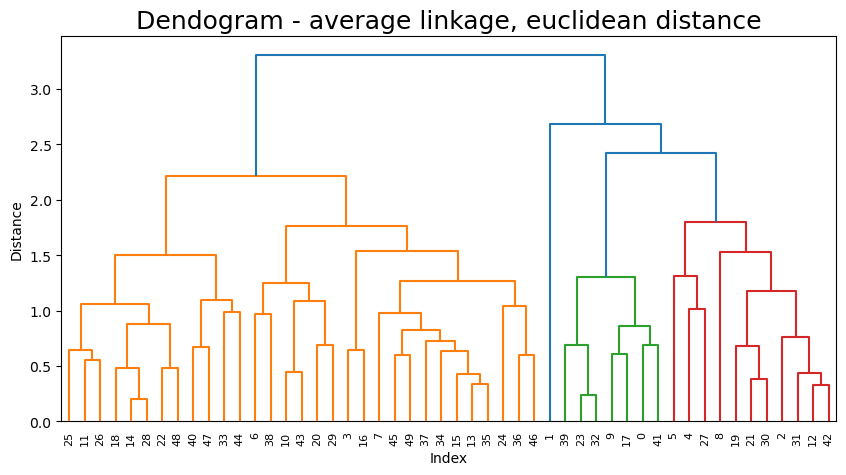

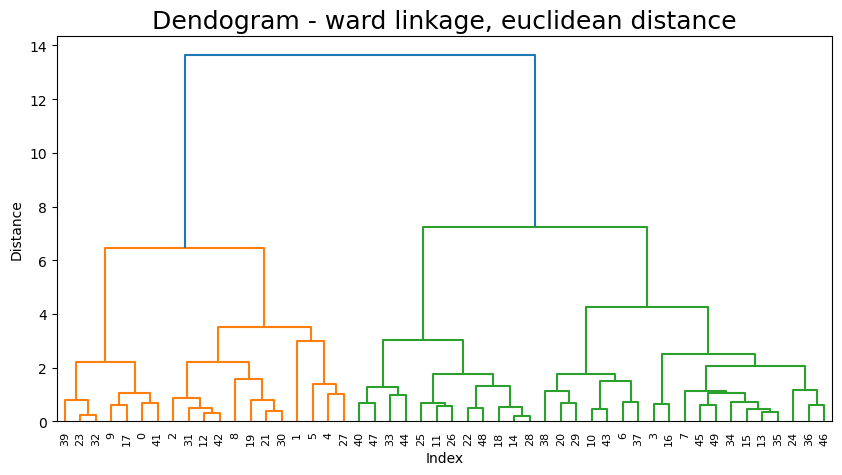

In [92]:
linkage_types = ['single', 'complete', 'average', 'ward']
distance_metric = 'euclidean'

for i, linkage_type in enumerate(linkage_types):
    dist = linkage(pca_df, method=linkage_type, metric=distance_metric)
    plt.figure(figsize=(10, 5))
    dendrogram(dist, leaf_rotation=90)
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.title("Dendogram - {} linkage, {} distance".format(linkage_type, distance_metric), fontsize=18)
    plt.show()

From the dendograms above it seems like there are 2 clusters.

In [98]:
# Verify the clusters obtained by using the Silhouette score 
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=1)
y_pred = kmeans.fit_predict(X)
score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'), 2)
score

0.43

<AxesSubplot:xlabel='cluster labels', ylabel='Assault'>

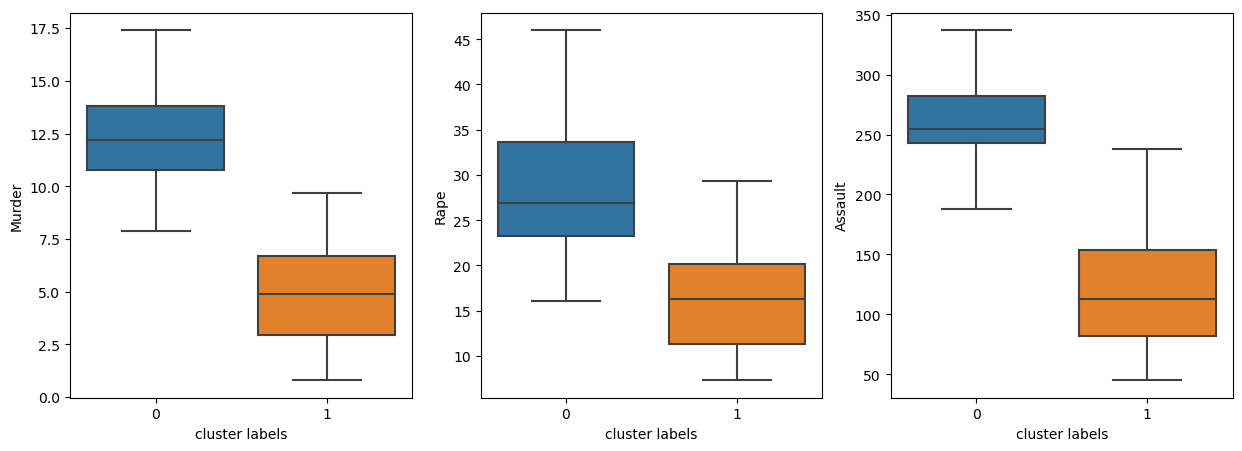

In [99]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.
df['cluster labels']=cluster_labels
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
sns.boxplot(x='cluster labels', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='cluster labels', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='cluster labels', y='Assault', data=df, ax=ax[2])

The box plots above suggest that states in Group 0 have higher crime rates and can be considered high-risk states, while states in Group 1 have relatively lower rates of murder, assault, and rape, and can be considered low-risk states.

In [101]:
for i in range(2):
    group_indices = np.argwhere(cluster_labels==i).transpose()[0]
    group = np.array(states)[group_indices]
    print(f'Group {i} States:', *group, sep=", ")
    print("\n")

Group 0 States:, Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas


Group 1 States:, Arkansas, Connecticut, Delaware, Hawaii, Idaho, Indiana, Iowa, Kansas, Kentucky, Maine, Massachusetts, Minnesota, Missouri, Montana, Nebraska, New Hampshire, New Jersey, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Dakota, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming


